# Library

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on device {device}")

Working on device cpu


# Load dataset

In [2]:
# Transform image to 1x784 and normalize colors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
trainset = datasets.MNIST('dataset', download=False, train=True, transform=transform)
valset_full = datasets.MNIST('dataset', download=False, train=False, transform=transform)

val_size, test_size = 1000, 9000
val_dataset, test_dataset = torch.utils.data.random_split(valset_full, [val_size, test_size], generator=torch.Generator().manual_seed(27))

# Create dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2000, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False) 

# Models

In [32]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        out = torch.nn.functional.tanh(self.dense1(X))
        out = torch.transpose(out, -1, -2)
        out = torch.nn.functional.tanh(self.dense2(out))
        out = torch.transpose(out, -2, -1)
        return out
    
class PFNN_2l_sq(nn.Module):
    def __init__(self, input_size, num_classes, device='cpu'):
        super(PFNN_2l_sq, self).__init__()
        
        self.PFFN1 = PositionWiseFFN(input_size,input_size)
        self.PFFN2 = PositionWiseFFN(input_size,input_size)
        
        dropout = 0.05
        self.dropout = nn.Dropout(dropout)
        
        # self.BN1 = nn.LayerNorm((1,input_size,input_size))
        
        self.W_o = nn.LazyLinear( num_classes, device=device)
        
        self.num_classes = num_classes

        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Multiply input by weights and add biases
        
        out = self.PFFN1(x)
        out = self.PFFN2(out)
        
        out = out.reshape(out.shape[0],-1)
        
        out = self.log_softmax(self.dropout(self.W_o(out)))
        
        return out

# Train loop

In [39]:
# Build the Neural Network
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

N_epoch = 60
model = PFNN_2l_sq(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\pffn_28-28_epoch_{N_epoch}.pth', map_location=torch.device('cpu'))) #
# print(model)
model.to(device)

# criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss which includes softmax
criterion = nn.NLLLoss()  # Use CrossEntropyLoss which includes softmax
optimizer = optim.Adam(model.parameters(), lr=18e-4, weight_decay=35e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97, verbose=False)

# Track loss
loss_list = []
val_loss_list = []

# Training the network
epochs = 30
time0 = time()

for epoch in range(epochs):
    running_loss = 0

    # for images, labels in tqdm(trainloader, leave=False):
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        images = images.squeeze(1)                 

        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)               
        
        # This is where the model learns by back propagating
        loss.backward()
        
        # And optimizes its weights here
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
    
    # validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.squeeze(1)                 
            
            output = model(images)
            val_loss = criterion(output, labels)
    val_loss = val_loss / len(val_loader)
    val_loss_list.append(val_loss)
        
    CE_curr = running_loss / len(trainloader)
    loss_list.append(CE_curr)
    # if (epoch%10)==0:
    print(f"Epoch {epoch} - Training loss: {CE_curr:.5f}, Val loss: {val_loss:.5f}")
    
    
print(f"\nTraining Time (in minutes) = {(time()-time0)/60:.2f}")

# Convert lists to numpy arrays
loss_array = np.array(loss_list)

val_loss = [val.cpu().numpy() for val in val_loss_list]

val_loss_array = np.array(val_loss)

# Save the model
torch.save(model.state_dict(), f'model_backup\pffn_28-28_epoch_{N_epoch+epochs}.pth')

c:\Users\m.vashkevich\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0 - Training loss: 0.10819, Val loss: 0.09223
Epoch 1 - Training loss: 0.05916, Val loss: 0.08668
Epoch 2 - Training loss: 0.05690, Val loss: 0.09135
Epoch 3 - Training loss: 0.05531, Val loss: 0.08802
Epoch 4 - Training loss: 0.05444, Val loss: 0.08873
Epoch 5 - Training loss: 0.05321, Val loss: 0.08744
Epoch 6 - Training loss: 0.05226, Val loss: 0.08688
Epoch 7 - Training loss: 0.05119, Val loss: 0.08761
Epoch 8 - Training loss: 0.05089, Val loss: 0.08490
Epoch 9 - Training loss: 0.05052, Val loss: 0.08643
Epoch 10 - Training loss: 0.04938, Val loss: 0.08519
Epoch 11 - Training loss: 0.04887, Val loss: 0.08662
Epoch 12 - Training loss: 0.04858, Val loss: 0.08506
Epoch 13 - Training loss: 0.04799, Val loss: 0.08640
Epoch 14 - Training loss: 0.04751, Val loss: 0.08446
Epoch 15 - Training loss: 0.04741, Val loss: 0.08384
Epoch 16 - Training loss: 0.04706, Val loss: 0.08529
Epoch 17 - Training loss: 0.04676, Val loss: 0.08529
Epoch 18 - Training loss: 0.04645, Val loss: 0.08505
Epo

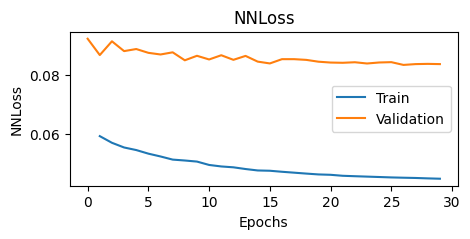

In [40]:
# epochs = 30
# N_epoch = 0
# # Save the model
# torch.save(model.state_dict(), f'model_backup\SDPA_2H_seq_d{d1}-d{d2}_pffn_epoch_{N_epoch+epochs}.pth')

# Plot NLL_loss
plt.figure(figsize=(5, 2))
plt.plot(range(len(loss_array))[1:], loss_array[1:], label='Train')
plt.plot(range(len(val_loss_array)), val_loss_array, label='Validation')

plt.xlabel('Epochs')
plt.ylabel('NNLoss')
plt.title('NNLoss')
plt.legend()
plt.show()

# NN test

In [41]:
input_size = 28  # 28x28 images flattened
output_size = 10  # 10 classes for digits 0-9

model = PFNN_2l_sq(input_size,output_size, device=device)
model.load_state_dict(torch.load(f'model_backup\pffn_28-28_epoch_{N_epoch+epochs}.pth', map_location=torch.device('cpu')))
# model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1000.pth'))
model.to(device)

correct = 0
total = 0

model.eval()
for X, y_true in test_loader:
    X = X.squeeze(1) 
    X = X.to(device)
    y_true = y_true.to(device)
    
    outputs = model(X)
    _,y_pred = torch.max(outputs, dim=1)
    total +=y_true.shape[0]
    correct +=int((y_pred==y_true).sum())

print(f"Accuracy = {correct/total: .4f}")

Accuracy =  0.9811


# Visualization

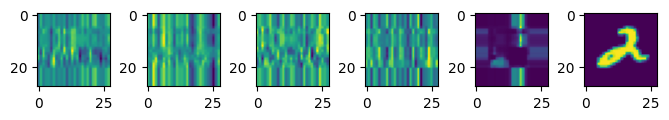

In [58]:
model = sa_NN(input_size,output_size, device=device)
model.load_state_dict(torch.load('model_backup\sa_NN_epoch_1400.pth')) # map_location=torch.device('cpu')

img, label = trainset[693]
img = img.to(device)

Q,K,V,Y,att_weights = model.get_matricies(img)

fig, ax = plt.subplots(figsize=(8,2), nrows=1, ncols=6)
plt.subplot(1,6,1)
plt.imshow(Q.squeeze(0).detach().cpu())
plt.subplot(1,6,2)
plt.imshow(K.squeeze(0).detach().cpu())
plt.subplot(1,6,3)
plt.imshow(V.squeeze(0).detach().cpu())
plt.subplot(1,6,4)
plt.imshow(Y.squeeze(0).detach().cpu())
plt.subplot(1,6,5)
plt.imshow(att_weights.squeeze(0).detach().cpu())
plt.subplot(1,6,6)
plt.imshow(img.squeeze(0).detach().cpu())

plt.subplots_adjust(wspace=0.5)